Define various useful functions and classes.

ImageSliceViewer3D is for the interactive visualization of a 3D image. The slices can be selected through a slider.

InteractiveStem adds a movable line in a stem plot. It also constructs an instance of ImageSliceViewer3D from a 3D image. A point in the stem plot correspond to a 2D-image. The position of the movable line in the stem plot determines the images which are displayed in the viewer. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.segmentation as seg
import src.imzmlio as imzmlio
import src.fusion as fusion
import nibabel as nib
import SimpleITK as sitk
import math
import os
import matplotlib.lines as lines
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import csv
import pandas
import ipywidgets as ipyw
import itkwidgets 
import scipy.misc
from IPython.display import clear_output
%matplotlib notebook

def transpose_eigenvectors(M, eigenvectors, eigenvalues):
    p, n = M.shape
    evT = [np.divide( (np.dot(M, eigenvectors[i])), (np.sqrt(2 * eigenvalues[i] * (n-1)/(p-1)))) for i in range(n)]
    return np.asarray(evT)

class ImageSliceViewer3D:
    """ 
    ImageSliceViewer3D is for viewing volumetric image slices in jupyter or
    ipython notebooks. 
    
    User can interactively change the slice plane selection for the image and 
    the slice plane being viewed. 

    Argumentss:
    Volume = 3D input image
    figsize = default(8,8), to set the size of the figure
    cmap = default('plasma'), string for the matplotlib colormap. You can find 
    more matplotlib colormaps on the following link:
    https://matplotlib.org/users/colormaps.html
    
    """
    
    def __init__(self, volume, mzs, ax=None, figsize=(8,8), cmap='gray'):
        self.volume = volume
        self.mzs = mzs
        self.figsize = figsize
        self.cmap = cmap
        self.ax = ax
        self.v = [np.min(volume), np.max(volume)]
        self.slider = ipyw.IntSlider(min=0, max=self.volume.shape[-1] - 1, step=1, continuous_update=False, 
            description='Image Slice:')
        
    def show(self):
        # Call to select slice plane
        ipyw.interact(self.view_selection, view=ipyw.RadioButtons(
            options=['x-y','y-z', 'z-x'], value='x-y', 
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'}))
    
    def view_selection(self, view):
        # Transpose the volume to orient according to the slice plane selection
        orient = {"y-z":[1,2,0], "z-x":[2,0,1], "x-y": [0,1,2]}
        self.vol = np.transpose(self.volume, orient[view])
        maxZ = self.vol.shape[2] - 1
        self.slider = ipyw.IntSlider(min=0, max=self.vol.shape[-1] - 1, step=1, continuous_update=False, 
            description='Image Slice:')
        # Call to view a slice within the selected slice plane
        ipyw.interact(self.plot_slice, z=self.slider)
        
    def update(self, image, mzs):
        self.volume = image
        self.vol = image
        self.mzs = mzs
        self.slider.max=self.volume.shape[-1] - 1
    
    def plot_slice(self, z):
        # Plot slice for the given plane and slice
        label = "value: "+ str(self.mzs[z])
        #print(label)
        if self.ax is None:
            self.fig = plt.figure(figsize=self.figsize)
            plt.title(label)
            plt.axis('off')
            plt.imshow(self.vol[:,:,z], cmap=plt.get_cmap(self.cmap))
        else:
            self.ax.set_title(label)
            self.ax.axis('off')
            self.ax.imshow(self.vol[:,:, z], cmap=plt.get_cmap(self.cmap))
            
            
class InteractiveStem():
    def __init__(self, ax, image):
        self.ax = ax
        self.ax_stem = ax[1]
        self.ax_viewer = ax[2]
        self.c = self.ax_stem.get_figure().canvas
        self.image = image

        line = self.ax_stem.lines[0]
        self.mzs = line.get_xdata()
        self.eigenvector = line.get_ydata()
                
        self.position = 0.1
        left, right = self.ax_stem.get_xlim()
        self.line = lines.Line2D([left, right], [self.position, self.position], picker=5, color="g")
        self.ax_stem.add_line(self.line)
        
        self.text = self.ax_stem.text(0,0, "", va="bottom", ha="left")
        
        self.viewer_restricted = ImageSliceViewer3D(image, [i for i in range(image.shape[-1])], ax=self.ax_viewer)
        self.viewer_restricted.show()
        
        self.c.draw_idle()
        self.sid = self.c.mpl_connect('pick_event', self.clickonline)

    def clickonline(self, event):
        self.text.set_text(event.artist)
        if event.artist == self.line:
            self.follower = self.c.mpl_connect("motion_notify_event", self.followmouse)
            self.releaser = self.c.mpl_connect('button_press_event', self.releaseonclick)

    def followmouse(self, event):
        self.line.set_ydata([event.ydata, event.ydata])
        self.c.draw_idle()
    
    def releaseonclick(self, event):
        self.position = event.ydata
        self.text.set_text("")
        indices = np.arange(0, len(self.mzs))
        cond = self.eigenvector > self.position if self.position > 0 else self.eigenvector < self.position
        indices_above_line = indices[cond]
        images_selected = self.image[..., indices_above_line]
        mzs_selected = self.mzs[indices_above_line]
        self.text.set_text(str(self.image.shape) + " " + str(images_selected.shape) + " " + str(mzs_selected.shape))
        self.viewer_restricted.update(images_selected, mzs_selected)
        self.c.mpl_disconnect(self.releaser)
        self.c.mpl_disconnect(self.follower)

Read the MALDI image (.nii) and the m/z information (.csv)

In [2]:
inputname = "/mnt/d/MALDI/imzML/MSI_20190419_01/00/peaksel_deisotoped.nii"
is_ratio = False
mzsname = "/mnt/d/MALDI/imzML/MSI_20190419_01/00/peaksel_deisotoped.csv"
threshold = 0
normname = None


if inputname.lower().endswith(".imzml"):
    imzml = imzmlio.open_imzml(inputname)
    image = imzmlio.to_image_array(imzml)
    mzs, intensities = imzml.getspectrum(0)
else:
    image = sitk.GetArrayFromImage(sitk.ReadImage(inputname)).T
    if mzsname:
        with open(mzsname) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=";")
            mzs = [float(row[0]) for row in csv_reader]
    else:
        mzs = [i for i in range(image.shape[2])]
    mzs = np.asarray(mzs)

image = image[..., mzs >= threshold]
mzs = mzs[mzs >= threshold]
mzs = np.around(mzs, decimals=2)



if normname is not None:
    print("Norm image detected")
    norm_img = sitk.ReadImage(normname)
    norm_img = sitk.GetArrayFromImage(norm_img).T
    norm_img_3D = norm_img[..., None]
    before = image.max()
    image = np.divide(image, norm_img_3D, out=np.zeros_like(image, dtype=np.float), where=norm_img_3D!=0)
    after = image.max()
    print("Before max=", before, ", after=", after)


if is_ratio:
    ratio_images, ratio_mzs = fusion.extract_ratio_images(image, mzs)
    image = np.concatenate((image, ratio_images), axis=2)
    mzs = np.concatenate((mzs, ratio_mzs))

Normalize the images such that their intensity is scaled between 0 and 255, according to the minimum and maximum value of each image.
Visualize the results with an image slider.

In [18]:
image = imzmlio.normalize(image)
image_shape = (image.shape[0], image.shape[1])
image_norm = seg.preprocess_pca(image)
M = image_norm.T
spectra_image = pandas.DataFrame(data=M, columns=mzs)


viewerSlice = ImageSliceViewer3D(image, mzs, figsize=(4,4))
viewerSlice.show()

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Compute the PCA on both the original and transposed matrix.

In [72]:
print("Computing PCA")
p, n = M.shape
fit_pca = fusion.pca(M, n)
eigenvectors = fit_pca.components_
eigenvalues = fit_pca.singular_values_
eigenvectors_transposed = transpose_eigenvectors(M, eigenvectors, eigenvalues)
print("Done")

Computing PCA
Done


Else use other dimension reduction techniques, such as NMF :

In [74]:
from sklearn.decomposition import NMF
print("Computing NMF")
p, n = M.shape
nb_comp = 5
nmf = NMF(n_components=nb_comp, init='nndsvda', solver='cd', random_state=0)
fit_nmf = nmf.fit(M)
eigenvectors = fit_nmf.components_ #H
eigenvalues = nmf.fit_transform(M); #W
eigenvectors_transposed = eigenvalues.T
print("Done")

Computing NMF
Done


In [64]:
print(eigenvectors.shape)
print(eigenvectors)
print(eigenvalues.shape)

(5, 208)
[[4.63914638e+00 5.34607746e+01 1.74706348e-03 ... 1.08358451e+02
  4.94786828e+01 6.26312918e+01]
 [2.72023532e-01 5.35454553e+00 1.27603532e-19 ... 1.70353128e+01
  1.43139007e+01 1.45360803e+01]
 [4.82984365e+00 1.61350123e+01 4.74082027e-01 ... 3.80911690e+00
  3.75484922e+01 4.15124573e+01]
 [1.81066114e+00 4.24342195e+01 4.56665233e+01 ... 5.61836981e+00
  2.24297584e+01 2.78136920e+01]
 [9.82552700e+00 4.49415093e+01 4.17579898e+00 ... 1.43125072e+01
  3.99922913e+01 4.79562396e+01]]
(20976, 5)


After the PCA is computed, explore the loadings of the transposed matrix (image for each axis, on the left) and the loadings of the original matrix on the same axis (stem plot, in the middle). Move the first slider to select an axis in the PCA. 

Move the green horizontal line ($y = a$) in the stem plot to visualize the images (on the right) :
  1. whose score is above $a$ for the selected axis, if $a > 0$.
  2. whose score is below $a$ for the selected axis, if $a \leq 0$
  
Move the second slider to visualize all of these images.

(152, 138, 208)


<IPython.core.display.Javascript object>


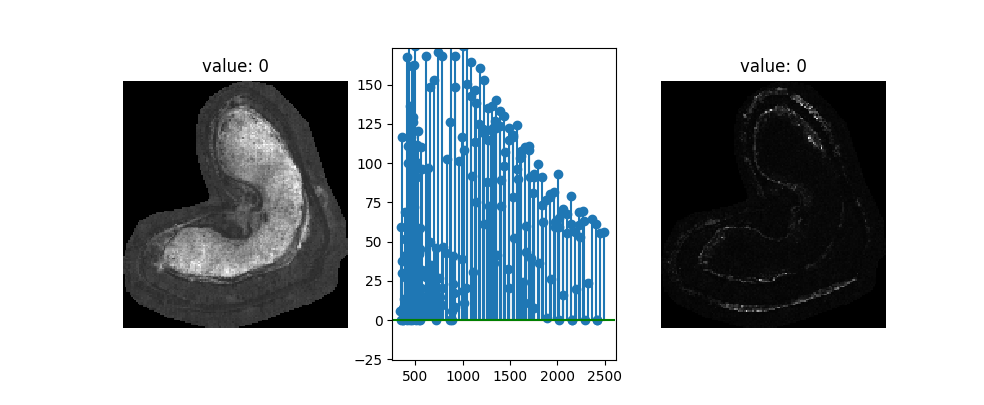

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [73]:
def plot_slice(viewer, z, ax):
    # Plot slice for the given plane and slice
    ImageSliceViewer3D.plot_slice(viewer, z)
    ax[1].clear()
    ax[2].clear()
    ax[1].stem(mzs, eigenvectors[z], use_line_collection=True)
    viewer.hline = InteractiveStem(ax, image)

plt.close()
image_eigenvectors = eigenvectors_transposed.T
new_shape = image_shape + (image_eigenvectors.shape[-1],)
print(new_shape)
image_eigenvectors = image_eigenvectors.reshape(new_shape)
fig, ax = plt.subplots(1, 3, figsize=(10,4))
viewer = ImageSliceViewer3D(image_eigenvectors, mzs=[i for i in range(new_shape[-1])], ax=ax[0])
viewer.plot_slice = lambda z: plot_slice(viewer,z, ax)
viewer.show()